In [1]:
from skimage.io import imread
import numpy as np
from scipy.fftpack import dct, idct
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import time


In [2]:
rootfolder = '.'

Definition of dct2 and idct2 (they are not builtin functions)

In [3]:
def dct2(s):
    return dct(dct(s.T, norm='ortho').T, norm='ortho')

def idct2(x):
    return idct(idct(x.T, norm='ortho').T, norm='ortho')

Useful function for plot the 2D DCT dictionary

In [4]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Load the image and rescale it in $[0,1]$

In [5]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255
imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [6]:
# np.random.seed(1)
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise


Compute the psnr of the noisy input

In [7]:
mse = np.mean((img-noisy_img)**2)
psnr_noisy = 10*np.log10(1/mse)
psnr_noisy

22.092114791101633

Text(0.5, 1.0, 'Noisy image, PSNR = 22.09')

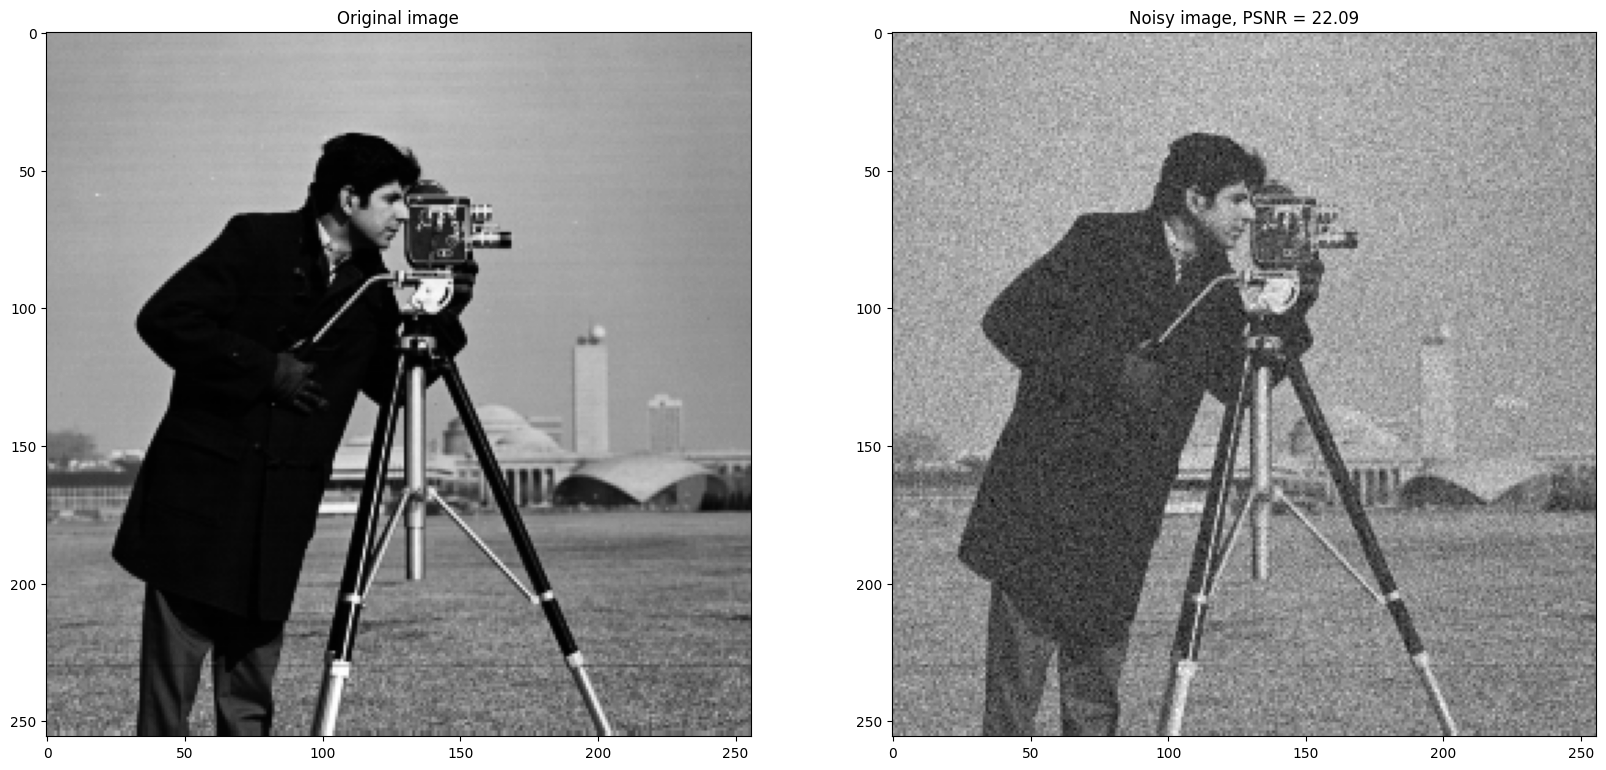

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


DCT denoising
-------------
Generate the DCT basis

In [9]:
D = np.zeros((M, M))
cnt = 0
for i in range(p):
    for j in range(p):
        a = np.zeros((p,p))
        a[i][j] = 1
        D[:, cnt] = np.reshape(idct2(a),-1)
        cnt = cnt + 1


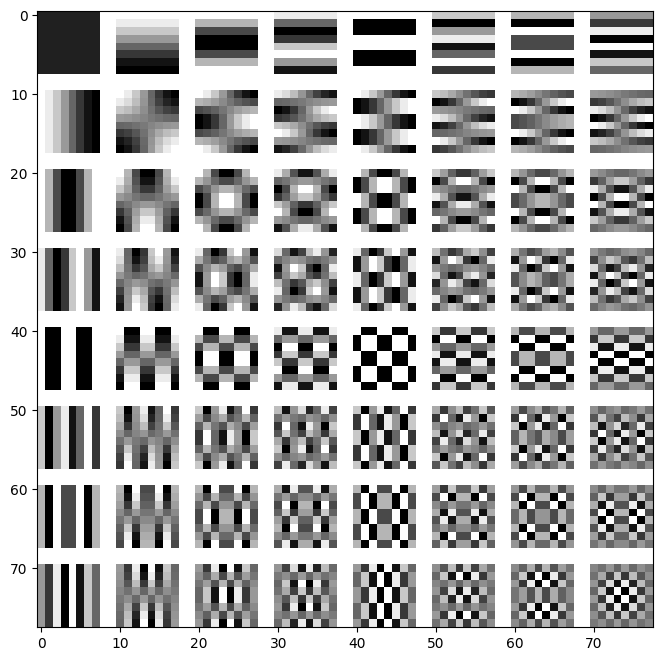

In [10]:
D_img = get_dictionary_img(D)
plt.figure(figsize=(8, 8))
plt.imshow(D_img, cmap='gray')

Denoising: set parameters and initialize the variables

In [11]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise # Donoho says: sigma * sqrt(2*log(p^2))

# define the step
STEP = 1

Perform the denoising pathwise

In [12]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p]

        # compute the representation w.r.t. the 2D DCT dictionary
        x = dct2(s)

        # perform the hard thresholding (do not perform HT on the DC!)
        x_HT = np.where(np.abs(x) >= tau, x, 0)
        x_HT[0,0] = x[0,0] # leave original value of DC

        # perform the reconstruction
        s_hat = idct2(x_HT)

        # compute the weight for the reconstructed patch
        nnz_coeff = np.count_nonzero(x_HT)
        w = 1/max(1,nnz_coeff)

        # put the compressed patch into the compressed image using the computed weight
        # update img_hat
        img_hat[i:i+p, j:j+p] = img_hat[i:i+p, j:j+p] + s_hat*w
        
        # store the weight of the current patch in the weight matrix
        # update weights
        weights[i:i+p, j:j+p] = weights[i:i+p, j:j+p] + w

Normalize the estimated image with the computed weights

In [13]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 29.12')

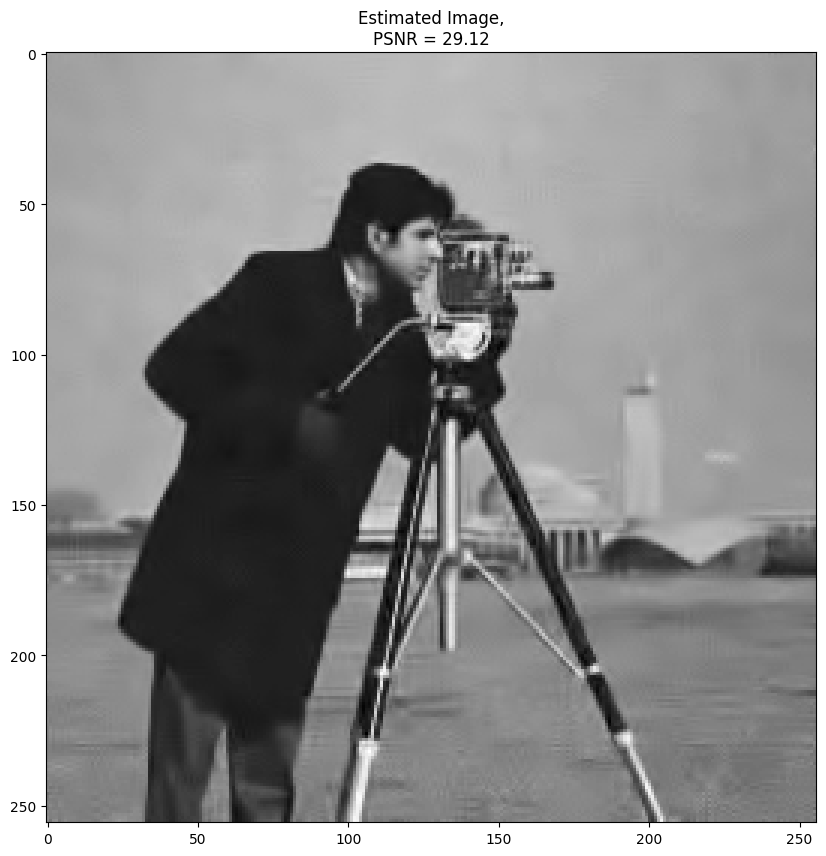

In [14]:
mse = np.mean((img-img_hat)**2)
psnr = 10*np.log10(1/mse)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr:.2f}')


Wiener Filtering
----------------
Initialize the estimated image via Wiener Filtering

Perform the denoising patchwise

In [15]:
# Initialize the estimated image via Wiener Filtering
img_hat_wiener = np.zeros_like(img)
weights = np.zeros_like(img)

# Perform the denoising patchwise
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch from the noisy image with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p] # S_ij

        # extrach the patch from the image estimated by HT with the top left corner at pixel (ii, jj)
        s_hat_HT = img_hat[i:i+p, j:j+p] #Y_ht_ij

        # compute the representation w.r.t. the 2D DCT dictionary
        x = dct2(s) # X_ij = (D.T)(S_ij)

        # perform the wiener filtering (do not filter the DC!)
        u = dct2(s_hat_HT) # U_ij = (D.T)(s_hat_HT)
        u = (u**2)/((sigma_noise**2)+(u**2))
        
        x_wie = u*x #np.dot(u, x) not equal (relieve-like image)
        x_wie[0,0] = x[0,0] # leave original value of DC
        
        # perform the reconstruction
        s_hat_wie = idct2(x_wie)

        # use uniform weights to aggregate the multiple estimates
        w = 1

        # put the compressed patch into the compressed image using the computed weight
        # update img_hat_wiener
        img_hat_wiener[i:i+p, j:j+p] += s_hat_wie*w # np.dot(D,s_hat_wie.reshape(-1))

        # store the weight of the current patch in the weight matrix
        # update weights
        weights[i:i+p, j:j+p] = weights[i:i+p, j:j+p] + w

# Normalize the estimated image with the computed weights
img_hat_wiener = img_hat_wiener/weights

Compute the psnr of the two estimates

Text(0.5, 1.0, 'Wiener Estimate, PSNR = 29.41')

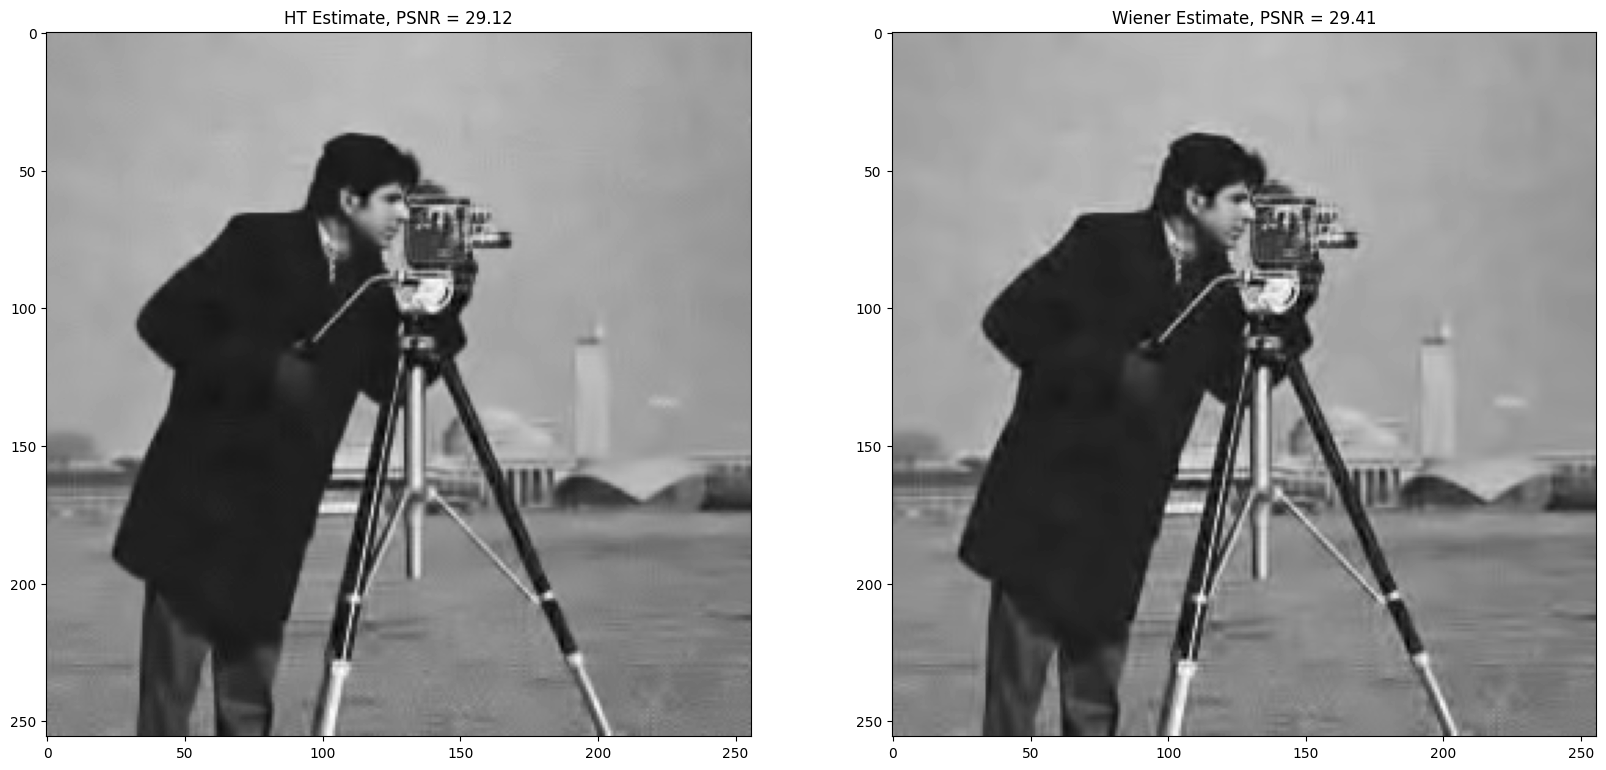

In [16]:
mse = np.mean((img-img_hat_wiener)**2)
psnr_wiener = 10*np.log10(1/mse)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img_hat, cmap='gray')
ax[0].set_title(f'HT Estimate, PSNR = {psnr:.2f}')

ax[1].imshow(img_hat_wiener, cmap='gray')
ax[1].set_title(f'Wiener Estimate, PSNR = {psnr_wiener:.2f}')


Noise estimation
----------------
Compute the horizontal derivative of the image

In [17]:
differences = noisy_img[:,1:] - noisy_img[:,:-1]

Compute sigma as the empirical std

In [18]:
sigma_hat_emp = np.std(differences)/np.sqrt(2)
sigma_hat_emp

0.10072375972530313

Use MAD to estimate the noise level sigma

In [19]:
from scipy.stats import norm
norm.ppf(3/4)

0.6744897501960817

In [20]:
mad = np.median(np.abs(differences - np.median(differences)))
sigma_hat = mad / (np.sqrt(2)*norm.ppf(3/4))
sigma_hat

0.08729934090009694

In [21]:
print(f'sigma: {sigma_noise:.3f}, sigma_hat (empirical std): {sigma_hat_emp:.3f}, sigma_hat (MAD): {sigma_hat:.3f}')


sigma: 0.078, sigma_hat (empirical std): 0.101, sigma_hat (MAD): 0.087
